This will be the main notebook, where data is loaded, investigated, prepared, and models are build, trained and experimented with.

In [109]:
# # test correct installion of environment
# import torchvision
# print(torchvision.__version__)

# import torch
# from torchvision.models.detection import fasterrcnn_resnet50_fpn
# model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
# model = model.cuda()
# print("model ok")
# print(torch.__version__)
# print(torch.version.cuda)
# print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
# !pip install torchmetrics

## Data Loading

In [110]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [111]:
# optional for google colab:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
root = '/content/drive/MyDrive/DL Medical Imaging/Project/Kvasir-SEG'

PATH_IMAGES = os.path.join(root, 'images')
PATH_LABELS = os.path.join(root, 'bbox')
PATH_ANNOTATED_IMAGES = os.path.join(root, 'annotated_images')

In [113]:
def load_images(directory_path):
    """ Returns a list of file paths to all .jpg images in the given directory. """
    image_files = []
    for filename in os.listdir(directory_path):
        if filename.lower().endswith('.jpg'):
            file_path = os.path.join(directory_path, filename)
            image_files.append(file_path)
    return sorted(image_files)

image_paths = load_images(PATH_IMAGES)
len(image_paths)

1000

In [114]:
def load_labels(label_dir):
    """
    Loads all CSV label files from the specified directory.
    Open each file, and save corners of each bounding box together with id/filename as new row.
    Combine everything into a single DataFrame and return it.
    """
    all_labels = []

    for filename in sorted(os.listdir(label_dir)):
        if filename.endswith(".csv"):
            file_id = os.path.splitext(filename)[0]
            df = pd.read_csv(os.path.join(label_dir, filename))
            df["id"] = file_id
            all_labels.append(df)

    labels_df = pd.concat(all_labels, ignore_index=True)

    return labels_df

labels_df = load_labels(PATH_LABELS)
labels_df.shape

(1071, 6)

We define the logic for loading an image with its belonging bounding boxes by implementing a torch dataset.

We implement two return formats, one suited for the use with a YOLO model, and a second for the use with a Faster RCNN model.

In [115]:
class KvasirPolypDataset(Dataset):
    """
    Dataset for Kvasir-SEG supporting:
      - YOLO format
      - Faster R-CNN format

    format="yolo":
        returns:
            image: Tensor (3, H, W)
            targets: Tensor (N, 5) [class, x_c, y_c, w, h] normalized
            img_id: str

    format="fasterrcnn":
        returns:
            id: str
            image: Tensor (3, H, W)
            target: dict {
                "boxes":  FloatTensor (N, 4) [xmin, ymin, xmax, ymax] (pixels)
                "labels": Int64Tensor (N,)
            }
    """

    def __init__(
        self,
        images_dir,
        labels_df,
        img_size=None,
        default_class=0,
        transforms=None,
        format="yolo",          # "yolo" or "fasterrcnn"
    ):
        super().__init__()

        assert format in ["yolo", "fasterrcnn"]
        self.format = format

        self.images_dir = images_dir
        self.img_paths = load_images(images_dir)
        self.img_size = img_size
        self.default_class = default_class
        self.transforms = transforms

        # id -> dataframe with boxes
        self.id_to_boxes = {
            img_id: group.reset_index(drop=True)
            for img_id, group in labels_df.groupby("id")
        }

        image_ids = {os.path.splitext(os.path.basename(p))[0] for p in self.img_paths}
        labeled_ids = set(self.id_to_boxes.keys())

        print(f"Total images: {len(image_ids)}")
        print(f"Images with at least one bbox: {len(labeled_ids)}")
        print(f"Images without bbox: {len(image_ids - labeled_ids)}")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img_id = os.path.splitext(os.path.basename(img_path))[0]

        # ---- load image ----
        img = read_image(img_path)
        if img is None:
            raise RuntimeError(f"Cannot read image: {img_path}")

        _, orig_h, orig_w = img.shape

        # ---- resize if needed ----
        if self.img_size is not None:
            img = F.resize(img, [self.img_size, self.img_size])
            new_h, new_w = self.img_size, self.img_size
            scale_x = new_w / orig_w
            scale_y = new_h / orig_h
        else:
            new_h, new_w = orig_h, orig_w
            scale_x = scale_y = 1.0

        # ---- normalize ----
        img = img.float() / 255.0

        df_boxes = self.id_to_boxes.get(img_id, None)

        # YOLO FORMAT
        # ------------
        if self.format == "yolo":
            targets = []

            if df_boxes is not None:
                for _, row in df_boxes.iterrows():
                    xmin = row["xmin"] * scale_x
                    ymin = row["ymin"] * scale_y
                    xmax = row["xmax"] * scale_x
                    ymax = row["ymax"] * scale_y

                    box_w = xmax - xmin
                    box_h = ymax - ymin
                    if box_w <= 0 or box_h <= 0:
                        continue

                    x_c = (xmin + box_w / 2) / new_w
                    y_c = (ymin + box_h / 2) / new_h
                    box_w /= new_w
                    box_h /= new_h

                    targets.append([
                        float(self.default_class),
                        x_c, y_c, box_w, box_h
                    ])

            if len(targets) > 0:
                targets = torch.tensor(targets, dtype=torch.float32)
            else:
                targets = torch.zeros((0, 5), dtype=torch.float32)

            return img, targets, img_id

        # FASTER R-CNN FORMAT
        # --------------------
        else:
            boxes = []
            labels = []

            if df_boxes is not None:
                for _, row in df_boxes.iterrows():
                    xmin = row["xmin"] * scale_x
                    ymin = row["ymin"] * scale_y
                    xmax = row["xmax"] * scale_x
                    ymax = row["ymax"] * scale_y

                    if xmax <= xmin or ymax <= ymin:
                        continue

                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(self.default_class + 1)  # 0 = background

            if len(boxes) > 0:
                target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32),
                    "labels": torch.tensor(labels, dtype=torch.int64),
                }
            else:
                target = {
                    "boxes": torch.zeros((0, 4), dtype=torch.float32),
                    "labels": torch.zeros((0,), dtype=torch.int64),
                }

            return img, target, img_id


In [116]:
dataset_fasterrcnn = KvasirPolypDataset(
    images_dir=PATH_IMAGES,
    labels_df=labels_df,
    img_size=512,
    default_class=0,
    format="fasterrcnn"
)

dataset_yolo = KvasirPolypDataset(
    images_dir=PATH_IMAGES,
    labels_df=labels_df,
    img_size=512,
    default_class=0,
    format="yolo"
)

Total images: 1000
Images with at least one bbox: 1000
Images without bbox: 0
Total images: 1000
Images with at least one bbox: 1000
Images without bbox: 0


## Data Analysis

Let's check if the raw images and belonging bounding boxes are loaded correctly by showing some instances and comparing them to the annotated images

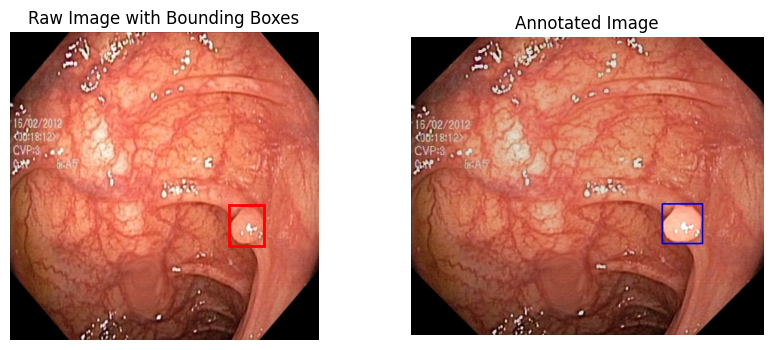

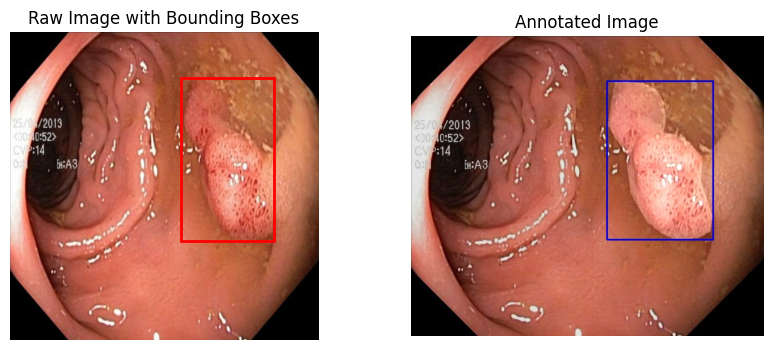

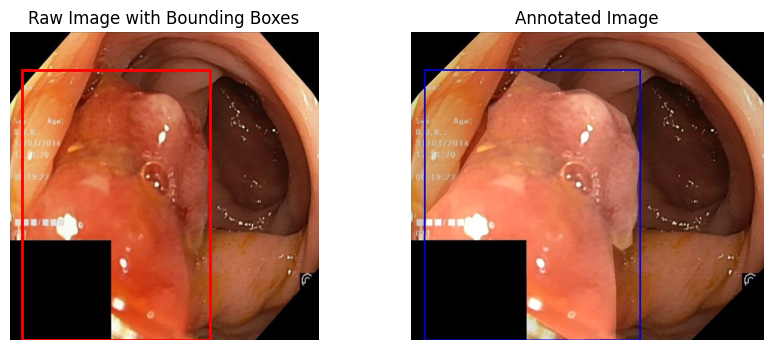

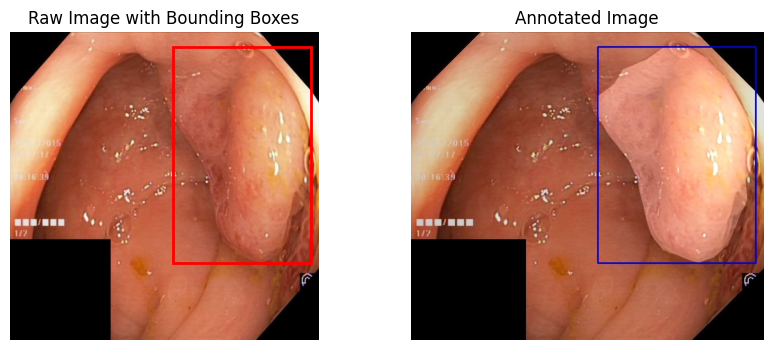

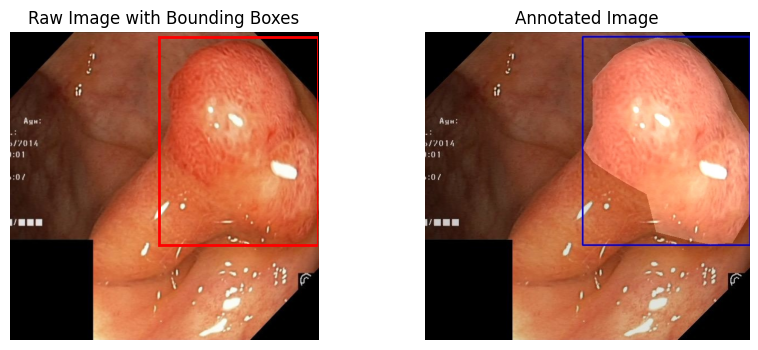

In [117]:
def plot_image_with_boxes(img, target, img_id):
    """
    Plots an image with bounding boxes.

    Args:
        img (Tensor): Image tensor of shape (3, H, W).
        target (dict): Target dictionary containing boxes and labels.
        img_id (str): Image identifier.
    """
    img_with_boxes = os.path.join(PATH_ANNOTATED_IMAGES, img_id + ".jpg")
    img_with_boxes = Image.open(img_with_boxes).convert("RGB")
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    img = img.permute(1, 2, 0).numpy()  # Convert to (H, W, 3) for plotting
    ax[0].imshow(img)
    ax[0].axis('off')

    for box, label in zip(target['boxes'], target['labels']):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].set_title(f'Raw Image with Bounding Boxes')

    ax[1].imshow(img_with_boxes)
    ax[1].set_title(f'Annotated Image')
    ax[1].axis('off')
    plt.show()

for i in range(5):
  img, target, img_id = dataset_fasterrcnn[i+100]
  plot_image_with_boxes(img, target, img_id)

Now let's see how potential images with multiple bounding boxes or no bounding boxes at all are handled.

In [118]:
total_boxes = 0
for _, target, _ in dataset_fasterrcnn:
    total_boxes += target["boxes"].shape[0]

print("Total bounding boxes:", total_boxes)

Total bounding boxes: 1071


Checking, if some images have multiple bounding boxes:

In [119]:
box_counts = []
for _, target, img_id in dataset_fasterrcnn:
    n_boxes = target["boxes"].shape[0]
    box_counts.append((img_id, n_boxes))
box_counts.sort(key=lambda x: x[1], reverse=True)
for img_id, n_boxes in box_counts[:5]:
    print(f"{img_id}: {n_boxes} bounding boxes")

cju3uhb79gcgr0871orbrbi3x: 10 bounding boxes
cju414lf2l1lt0801rl3hjllj: 4 bounding boxes
cju0roawvklrq0799vmjorwfv: 3 bounding boxes
cju32a52lb9rc0799xi40qs00: 3 bounding boxes
cju43c92lm5cj0755lorsorfg: 3 bounding boxes


Checking if the multiple bounding boxes are correctly plotted:

Visualizing: cju0roawvklrq0799vmjorwfv


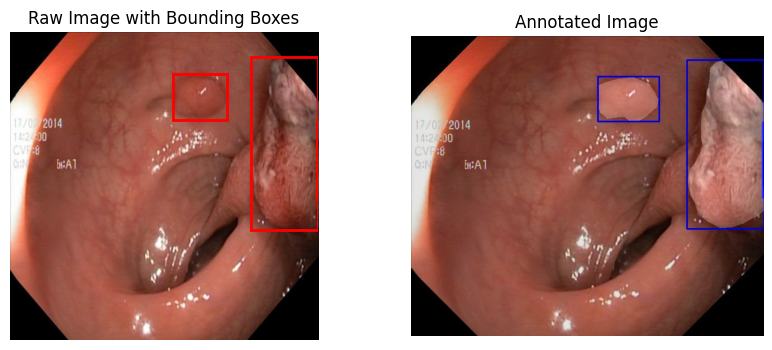

In [120]:
for img, target, img_id in dataset_fasterrcnn:
    if target["boxes"].shape[0] > 1:
        print("Visualizing:", img_id)

        plot_image_with_boxes(img, target, img_id)
        break

Checking if some images have no bounding box at all:

In [121]:
image_ids = {os.path.splitext(os.path.basename(path))[0] for path in image_paths}
labeled_ids = set(labels_df['id'].unique())
unlabeled_ids = image_ids - labeled_ids
len(unlabeled_ids)  # should be 0 if all images are labeled

0

## Batch Data Loaders

In order to load the images in batches, we define batch generating functions. Again one for YOLO format and one for Faster RCNN format.

For yolo, we have to implement the batch generating function by ourselves:

In [122]:
def collate_fn_fasterrcnn(batch):
    return tuple(zip(*batch))

def collate_fn_yolo(batch):
    """
    Custom collate function for YOLO-format batches.

    Takes a list of (image, targets, img_id) tuples and combines them into:
        - images: stacked tensor of shape (B, 3, H, W)
        - all_targets: concatenated tensor of shape (M, 6) where each row is
          [batch_index, class, x_center, y_center, width, height]
        - img_ids: list of image identifiers
    """
    images = []
    all_targets = []
    img_ids = []

    for i, (img, targets, img_id) in enumerate(batch):
        images.append(img)
        img_ids.append(img_id)

        if targets.numel() > 0:
            # add column with the index of the image in the batch
            batch_idx = torch.full(
                (targets.size(0), 1),
                i,
                dtype=targets.dtype
            )
            # [batch_idx, class, x_c, y_c, w, h]
            t = torch.cat([batch_idx, targets], dim=1)
            all_targets.append(t)

    images = torch.stack(images, dim=0)  # (B,3,H,W)

    if len(all_targets) > 0:
        all_targets = torch.cat(all_targets, dim=0)
    else:
        all_targets = torch.zeros((0, 6), dtype=torch.float32)

    return images, all_targets, img_ids

Split the dataset in train, validation and test set

In [123]:
# --- FASTER RCNN ---

# Define the split ratios
train_size = int(0.6 * len(dataset_fasterrcnn))  # 60% of the data for training
val_size = int(0.3 * len(dataset_fasterrcnn))  # Remaining 20% for testing
test_size = len(dataset_fasterrcnn)-train_size-val_size  # Remaining samples for validation

# Split the dataset. Use the function random_split with the obtained sizes
train_dataset_fasterrcnn, test_dataset_fasterrcnn = random_split(dataset_fasterrcnn, [train_size, val_size + test_size])
val_dataset_fasterrcnn, test_dataset_fasterrcnn = random_split(test_dataset_fasterrcnn, [val_size, test_size])


# split the train in validation and train

# --- YOLO ---

# Define the split ratios
train_size = int(0.6 * len(dataset_yolo))  # 60% of the data for training
val_size = int(0.3 * len(dataset_yolo))  # Remaining 20% for testing
test_size = len(dataset_yolo)-train_size-val_size  # Remaining samples for validation

# Split the dataset. Use the function random_split with the obtained sizes
train_dataset_yolo, test_dataset_yolo = random_split(dataset_yolo, [train_size, val_size + test_size])
val_dataset_yolo, test_dataset_yolo = random_split(test_dataset_yolo, [val_size, test_size])


In [124]:
train_dataloader_fasterrcnn = DataLoader(
    train_dataset_fasterrcnn,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn_fasterrcnn
)

val_dataloader_fasterrcnn = DataLoader(
    val_dataset_fasterrcnn,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn_fasterrcnn
)

test_data_loader = DataLoader(
    test_dataset_fasterrcnn,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn_fasterrcnn
)

train_dataloader_yolo = DataLoader(
    train_dataset_yolo,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn_yolo
)

val_dataloader_yolo = DataLoader(
    val_dataset_yolo,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn_yolo
)

test_data_loader_yolo = DataLoader(
    test_dataset_yolo,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn_yolo
)

# try to iterate one batch
for images, targets, img_ids in train_dataloader_yolo:
    print("Batch images shape:", images.shape)  # (B,3,H,W)
    print("Targets shape:", targets.shape)      # (M,6) -> [batch_idx, class, x_c, y_c, w, h]
    print("Example img_ids:", img_ids[:3])
    break

Batch images shape: torch.Size([1, 3, 512, 512])
Targets shape: torch.Size([1, 6])
Example img_ids: ['cju88nroho44508500129f1nh']


## Utils For Training

In [140]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    torch.save(checkpoint, path)

In [126]:
def load_checkpoint(path, model, optimizer=None, scheduler=None, device="cuda"):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    start_epoch = checkpoint["epoch"] + 1
    train_losses = checkpoint.get("train_losses", [])
    val_losses = checkpoint.get("val_losses", [])

    return start_epoch, train_losses, val_losses

Validation Loop

In [132]:
def evaluate_model_with_metrics(model, dataloader, device, iou_match_thr = 0.3,save_outputs = False):

    """
    Evaluates Faster R-CNN model and computes mAP, accuracy, and IoU.

    Args:
        model : The object detection model.
        dataloader : Dataloader for the validation/test dataset.
        device : Device to run the evaluation
        iou_match_thr: IoU threshold to consider a prediction matched to a GT
        save_outputs: if True, returns also all_outputs (list) with predictions + img_ids

    Returns:
        dict: Dictionary containing mAP, accuracy, and Jaccard Index (IoU).
    """

    model.to(device)
    metric = MeanAveragePrecision()

    total_correct = 0
    total_predictions = 0
    total_iou = 0.0
    all_outputs = []

    val_loss = 0
    n_batches = 0
    with torch.no_grad():
        for images, targets,img_ids in tqdm(dataloader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # --- VALIDATION LOSS ---
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            n_batches += 1


            # Get model predictions for images
            model.eval()
            outputs = model(images)

            # Create list with predictions on cpu
            preds = []
            for output in outputs:
                preds.append({
                    "boxes": output['boxes'].cpu(),
                    "scores": output["scores"].cpu(),
                    "labels": output['labels'].cpu(),
                })

            # Create list with GT on cpu
            gt = []
            for target in targets:
                gt.append({
                    "boxes": target['boxes'].detach().cpu(),
                    "labels": target["labels"].detach().cpu(),
                })

            metric.update(preds, gt)

            # Calculate accuracy and IoU
            for pred, truth in zip(outputs, targets):
                pred_boxes = pred["boxes"]
                pred_labels = pred["labels"]
                gt_boxes = truth["boxes"]
                gt_labels = truth["labels"]

                if len(gt_boxes) > 0 and len(pred_boxes) > 0:
                    ious = box_iou(pred_boxes, gt_boxes)
                    max_ious, max_indices = ious.max(dim=1)

                    # Count IoU values above threshold
                    matched = max_ious > iou_match_thr

                    if matched.any():
                        total_correct += (pred_labels[matched] == gt_labels[max_indices[matched]]).sum().item()
                        total_predictions += matched.sum().item()
                        total_iou += max_ious[matched].sum().item()

            if save_outputs:
              for out,img_id in zip(outputs,img_ids):
                all_outputs.append({
                    'img_id': img_id,
                    'boxes': out['boxes'].detach().cpu(),
                    'labels': out['labels'].detach().cpu(),
                    'scores': out['scores'].detach().cpu(),
                })

    avg_val_loss = val_loss / n_batches if n_batches > 0 else 0.0


    # Compute final metrics
    results = metric.compute() # mAP metric
    accuracy = total_correct / total_predictions if total_predictions > 0 else 0.0
    mean_iou = total_iou / total_predictions if total_predictions > 0 else 0.0

    final_results = {
        "val_loss": avg_val_loss,
        "mAP": results["map"].item(),
        "mAP_50": results["map_50"].item() if "map_50" in results else None,
        "mAP_75": results["map_75"].item() if "map_75" in results else None,
        "Accuracy_matched": accuracy,
        "IoU_matched": mean_iou,
        "Matched_count": total_predictions,
    }
    if save_outputs:
        return final_results, all_outputs
    else:
        return final_results

## Standard Faster RCNN

### Training

In [133]:
model = fasterrcnn_resnet50_fpn(
    weights="DEFAULT"
)

# replace classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features,
    2               # 0 background, 1 polyp
)

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.0025,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=7,
    gamma=0.1
)

In [141]:
checkpoint_path = "/content/drive/MyDrive/checkpoints/fasterrcnn_epoch_11.pth"

val_losses = []

if os.path.exists(checkpoint_path):
    print(f"Checkpoint found: {checkpoint_path}")
    start_epoch, train_losses, val_losses = load_checkpoint(
        checkpoint_path,
        model,
        optimizer,
        lr_scheduler,
        device=device
    )
else:
    print("Checkpoint not found, starting training from the beginning")
    start_epoch = 0
    train_losses = []
    val_losses = []


history = []  # dict list: 1 dict per epoch
num_epochs = 15


for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0.0
    n_batches = 0

    for images, targets, _ in train_dataloader_fasterrcnn:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        n_batches += 1

    lr_scheduler.step()

    avg_epoch_loss = epoch_loss / n_batches
    train_losses.append(avg_epoch_loss)

    val_results = evaluate_model_with_metrics(
        model,
        val_dataloader_fasterrcnn,
        device,
        iou_match_thr=0.3,
        save_outputs=False
    )

    val_losses.append(val_results["val_loss"])


    save_checkpoint(
        model,
        optimizer,
        lr_scheduler,
        epoch,
        train_losses,
        val_losses,
        f"/content/drive/MyDrive/checkpoints/fasterrcnn_epoch_{epoch+1}.pth"
    )

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {avg_epoch_loss:.4f} | "
        f"Val Loss: {val_losses[-1]:.4f} | "
        f"mAP: {val_results['mAP']*100:.2f}%"
    )


Checkpoint not found, starting training from the beginning


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.25it/s]


Epoch [1/15] | Train Loss: 0.0966 | Val Loss: 0.1399 | mAP: 56.40%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


Epoch [2/15] | Train Loss: 0.0808 | Val Loss: 0.1275 | mAP: 60.55%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


Epoch [3/15] | Train Loss: 0.0689 | Val Loss: 0.1277 | mAP: 60.27%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


Epoch [4/15] | Train Loss: 0.0607 | Val Loss: 0.1337 | mAP: 61.15%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.20it/s]


Epoch [5/15] | Train Loss: 0.0564 | Val Loss: 0.1232 | mAP: 64.77%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.25it/s]


Epoch [6/15] | Train Loss: 0.0399 | Val Loss: 0.1155 | mAP: 64.25%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.22it/s]


Epoch [7/15] | Train Loss: 0.0355 | Val Loss: 0.1181 | mAP: 64.71%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.22it/s]


Epoch [8/15] | Train Loss: 0.0339 | Val Loss: 0.1177 | mAP: 65.19%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


Epoch [9/15] | Train Loss: 0.0324 | Val Loss: 0.1203 | mAP: 65.86%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


Epoch [10/15] | Train Loss: 0.0314 | Val Loss: 0.1215 | mAP: 65.51%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.21it/s]


Epoch [11/15] | Train Loss: 0.0304 | Val Loss: 0.1213 | mAP: 65.41%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.22it/s]


Epoch [12/15] | Train Loss: 0.0298 | Val Loss: 0.1216 | mAP: 65.35%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.22it/s]


Epoch [13/15] | Train Loss: 0.0281 | Val Loss: 0.1218 | mAP: 65.57%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.21it/s]


Epoch [14/15] | Train Loss: 0.0283 | Val Loss: 0.1223 | mAP: 65.22%


Evaluating: 100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


Epoch [15/15] | Train Loss: 0.0282 | Val Loss: 0.1230 | mAP: 65.52%


Visualize the loss in training through the 20 epochs.

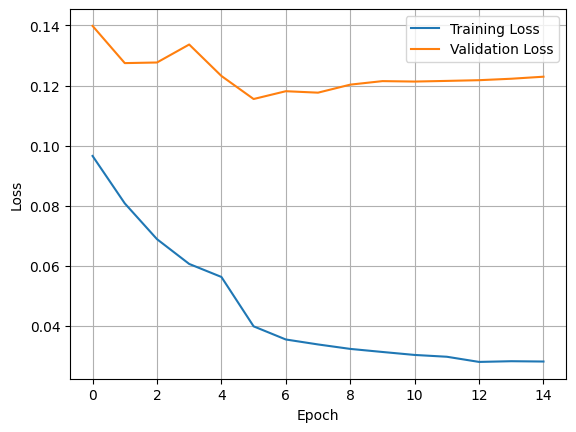

In [142]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Qualitative Evaluation Loop

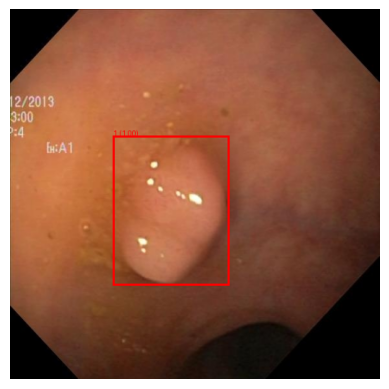

In [143]:
# Visualization
def visualize_predictions(image, predictions, confidence_threshold):
    """
    Visualizes bounding boxes with high confidence, assigning unique colors to each label.

    Args:
        image (PIL.Image.Image): The input image.
        predictions (dict): Model predictions containing 'boxes', 'labels', and 'scores'.
        confidence_threshold (float): Minimum score to visualize a prediction.
    """
    # Extract bounding boxes, labels, and scores from predictions
    boxes = predictions['boxes']  # List of predicted bounding boxes (each box is a tensor of [xmin, ymin, xmax, ymax])
    labels = predictions['labels']  # List of predicted class labels
    scores = predictions['scores']  # List of predicted confidence scores for each bounding box

    # Filter predictions based on confidence threshold
    high_conf_indices = torch.where(scores >= confidence_threshold)[0] # create a list with indices of scores that are higher than the confidence_threshold
    boxes = [boxes[i].tolist() for i in high_conf_indices] # create a list of lists with the boxes corresponding to the high_conf_indices
    labels = [labels[i].item() for i in high_conf_indices] # create a list of the labels corresponding to the high_conf_indices
    scores = [scores[i].item() for i in high_conf_indices] # create a list of the scores corresponding to the high_conf_indices

    # Draw the bounding boxes on the image
    image_draw = image.copy()
    draw = ImageDraw.Draw(image_draw)
    for box, label, score in zip(boxes, labels, scores):
        color = 'red' # select the color of the class
        draw.rectangle(box, outline=color, width=3) # plot the box
        draw.text((box[0], max(0, box[1] - 10)), f"{label} ({score:.2f})", fill=color) # plot text

    return image_draw
# Test on an example
# Obtain the next batch from test_loader using 'next' and 'iter'
batch_images, batch_targets, batch_img_ids = next(iter(val_dataloader_fasterrcnn))
image_to_visualize = batch_images[0] # Take the first image from the batch

# Evaluate on an image.
# Set the model to evaluation mode (disables dropout, batch norm, etc.)
model.eval()
with torch.no_grad():
    image = batch_images[0].to(device)  # Fetch a batch image from the dataset
    prediction = model([image])

    # Convert image tensor to PIL Image
    pil_image = F.to_pil_image(batch_images[0])

    confidence_treshold = 0.6

    high_conf_image = visualize_predictions(pil_image, prediction[0], confidence_threshold)
    # Show the image
    plt.imshow(high_conf_image)
    plt.axis("off")
    plt.show()